Import packages:

In [1]:
from IPython.display import clear_output
!pip install paddle-quantum==2.1.0
clear_output()

In [2]:
import paddle
from paddle import matmul
from paddle_quantum.circuit import UAnsatz
from paddle_quantum.utils import pauli_str_to_matrix, dagger
from paddle_quantum.VQE.chemistrysub import H2_generator

import os
import matplotlib.pyplot as plt

import numpy as np
from numpy import pi as PI 
from numpy import savez, zeros
from scipy.sparse import diags
from scipy import sparse

# Eliminate noisy python warnings
import warnings
warnings.filterwarnings("ignore")

Encode problem Hamiltonian:

In [3]:
N = 4   # number of qubits
dim = 2**N # dimension of the operator A

# Setup a tridiagonal matrix
k = [np.ones(dim-1), -2*np.ones(dim), np.ones(dim-1)]
offset = [-1, 0, 1]
A = diags(k,offset).toarray()

# Setup the driving term f(x) = x
b = np.linspace(0, 1, dim)
# b = [h**2 for x in np.arange(0,1+h,h)]
h = 1/(dim-1)
# b = np.ones(dim)
bt = np.linspace(0, 1, dim)
b = b*(h**2)

# Setup the Dirichlet B.C.s
phi_a, phi_b = 0, 0
b[0] -= phi_a
b[dim-1] -= phi_b
norm = np.linalg.norm(b)
b = b/norm

# Solve the linear system of equations
x = np.linalg.solve(A, b)
f = np.linalg.norm(x)
x = x/f

# Build Hamiltonian
b = b.reshape([dim, 1])
Hamiltonian = A@(np.eye(dim)- b@b.T)@A
H = paddle.to_tensor(Hamiltonian)
# print(Hamiltonian)

print("Classical solution:\n", x)
eig_val, eig_state = np.linalg.eig(Hamiltonian)
# print("Eigenvalues:\n", eig_val)
# print(min(eig_val))
vec = eig_state[:,-1]
# print(eig_state)
print("Eigenvector:\n",vec)

Classical solution:
 [-0.04853869 -0.09707737 -0.14440259 -0.18930087 -0.23055876 -0.26696277
 -0.29729945 -0.32035532 -0.33491693 -0.3397708  -0.33370346 -0.31550146
 -0.28395131 -0.23783956 -0.17595273 -0.09707737]
Eigenvector:
 [0.04853869 0.09707737 0.14440259 0.18930087 0.23055876 0.26696277
 0.29729945 0.32035532 0.33491693 0.3397708  0.33370346 0.31550146
 0.28395131 0.23783956 0.17595273 0.09707737]


Build parametrized quantum circuit here:

In [4]:
def U_theta(theta, Hamiltonian, N, D, p):
    """
    Quantum Neural Network
    """
    
    # Initialize the quantum neural network according to the number of qubits N
    cir = UAnsatz(N)

    ## ============= QAOA Ansatz ================
    # cir.superposition_layer()
    
    for idx in range(p):
      for i in range(N):
          cir.ry(theta=theta[idx][i][0], which_qubit=i)
      cir.h(0)

      ## ZZ interaction
      for i in range(N-1):
          cir.cnot([i, i+1]) 
          cir.ry(theta=theta[idx+1][i][0], which_qubit=i+1)   
          cir.cnot([i, i+1])  

      cir.cnot([N-1, 0]) 
      cir.ry(theta=theta[idx+1][N-1][0], which_qubit=0)   
      cir.cnot([N-1, 0]) 

      ## YY interaction
      # cir.ryy(theta=theta[idx+2][0][0], which_qubits=[0, 1])

    # Built-in {R_y + CNOT} circuit template
    # cir.real_entangled_layer(theta[:D], D)

    ## ============= HEA Ansatz ================
    # Lay R_y gates in the last row
    # for i in range(N):
        # cir.rx(theta=theta[D][i][0], which_qubit=i)
    #     cir.depolarizing(0.4, i)


    return cir


In [5]:
class StateNet(paddle.nn.Layer):

    def __init__(self, shape, dtype="float64"):
        super(StateNet, self).__init__()
        
        # Initialize the theta parameter list and fill the initial value with a uniform distribution of [0, 2*pi]
        self.theta = self.create_parameter(shape=shape, default_initializer=paddle.nn.initializer.Uniform(low=0.0, high=2*PI), dtype=dtype, is_bias=False)
        
    # Define loss function and forward propagation mechanism
    def forward(self, H, N, D, p):
        
        cir = U_theta(self.theta, H, N, D, p)
        U = cir.U

        U_np = cir.U.numpy().real
        state_vec = U_np[:,0]
        fidelity = abs(state_vec@x.T)**2

        # Calculate the expected value of a given Hamiltonian
        # loss_list = paddle.real(matmul(matmul(dagger(U), H), U))
        # loss = loss_list[0][0]

        loss_struct = paddle.real(matmul(matmul(dagger(U), H), U))
        E0 = loss_struct[0][0]
        loss = loss_struct[0][0]

        # Enter the computational basis to calculate the expected value 
        # which is equivalent to taking the diagonal element of U^dagger*H*U
        # loss_components = []
        # for i in range(len(loss_struct)):
        #     loss_components.append(loss_struct[i][i])
        
        # # Weighted summation of loss function
        # loss = 0
        # for i in range(2):
        #     weight = dim - i
        #     loss += weight * loss_components[i]

        return loss, E0, cir, fidelity

Train the QNN

In [6]:
ITR = 200   # Set the number of optimization iterations
LR = 0.4   # Set the learning rate
p = 4
D = 2*p     # Set the depth of the repetitive calculation module in QNN

In [ ]:
# Determine the parameter dimension of the network
net = StateNet(shape=[D + 1, N, 1])

# Generally speaking, we use Adam optimizer to obtain relatively good convergence,
# You can change it to SGD or RMS prop.
# opt = paddle.optimizer.Adam(learning_rate=LR, parameters=net.parameters())
opt = paddle.optimizer.Adam(learning_rate=LR, parameters=net.parameters())

# Record optimization results
summary_iter, summary_loss, state_vec, summary_E0, summary_fid = [], [], [], [], []

# Optimization loop
for itr in range(1, ITR + 1):

    # Forward propagation to calculate loss function
    loss, E0, cir, fid = net(H, N, D, p)

    # Use back propagation to minimize the loss function
    loss.backward()
    opt.minimize(loss)
    opt.clear_grad()

    # Record optimization results
    summary_loss.append(loss.numpy())
    summary_iter.append(itr)
    summary_E0.append(E0)
    summary_fid.append(fid)

    # Print result
    if itr % 50 == 0:
        print("iter:", itr, "loss:", "%.8f" % E0.numpy())
        print("iter:", itr, "fidelity:", "%.8f" % fid)
        # print("iter:", itr, "Ground state energy:", "%.8f Ha" % loss.numpy())

    if itr == ITR:
        print("The solution fidelity F = ", fid)
        print("\nThe trained circuit:")
        print(cir)
        U = cir.U.numpy().real
        state_vec = U[:,0]
      
# Save the training results to the output folder
os.makedirs("output", exist_ok=True)
savez("./output/summary_data", iter = summary_iter, energy=summary_E0)

Convergence Analysis:

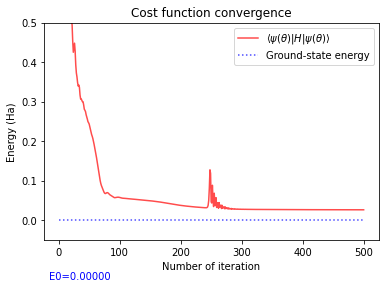

In [ ]:
result = np.load('./output/summary_data.npz')

eig_val, eig_state = np.linalg.eig(H)
min_eig_H = np.min(eig_val.real)
min_loss = np.ones([len(result['iter'])]) * min_eig_H

plt.figure(1)
func1, = plt.plot(result['iter'], result['energy'], 
                  alpha=0.7, marker='', linestyle="-", color='r')
func_min, = plt.plot(result['iter'], min_loss, 
                  alpha=0.7, marker='', linestyle=":", color='b')
plt.xlabel('Number of iteration')
plt.ylabel('Energy (Ha)')
plt.ylim(-0.05, 0.5)

plt.legend(handles=[func1,func_min],
    labels=[
        r'$\left\langle {\psi \left( {\theta } \right)} '
        r'\right|H\left| {\psi \left( {\theta } \right)} \right\rangle $',
        'Ground-state energy',
    ], loc='best')
plt.text(-15.5, -0.15, f'E0={min_eig_H:.5f}', fontsize=10, color='b')
plt.title("Cost function convergence")
# plt.savefig("vqe.png", bbox_inches='tight', dpi=300)
plt.show()

Text(150.5, 1.01, 'F=0.00000299')

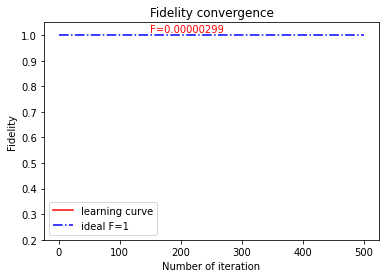

In [ ]:
plt.plot(summary_iter, summary_fid, 'r-', label='learning curve')
plt.plot(summary_iter, np.ones(ITR), 'b-.', label='ideal F=1')
plt.ylim([0.2, 1.05])
plt.legend(loc="lower left")
plt.xlabel('Number of iteration')
plt.ylabel('Fidelity')
plt.title("Fidelity convergence")
plt.text(150.5, 1.01, f'F={fid:.8f}', fontsize=10, color='r')
# plt.savefig("fid.png", bbox_inches='tight', dpi=300)

Benchmark with analytical solutions:

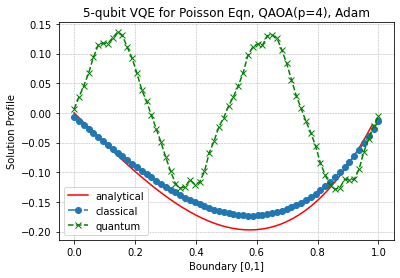

In [ ]:
t = np.arange(0., 1., 0.02)
res = (t**3-t)/6
norm_res = np.linalg.norm(res)
res_norm = res/norm_res

xt = np.arange(0,1,1/dim)
exact = [1/6*(x**3-x) for x in np.arange(0,1,1/dim)]
norm = np.linalg.norm(exact)
exact = exact/norm

# red dashes, blue squares and green triangles
plt.plot(t, res_norm, 'r-', label='analytical')
plt.plot(bt, x, 'o-.', label='classical')
plt.plot(bt, state_vec, 'gx--', label='quantum')
# plt.legend()
plt.legend(loc="lower left")
plt.xlabel('Boundary [0,1]')
plt.ylabel('Solution Profile')
plt.title("5-qubit VQE for Poisson Eqn, QAOA(p=4), Adam")
plt.grid(linestyle = '--', linewidth = 0.5)
# plt.show()
# plt.savefig("5qsoln.png", bbox_inches='tight', dpi=300)

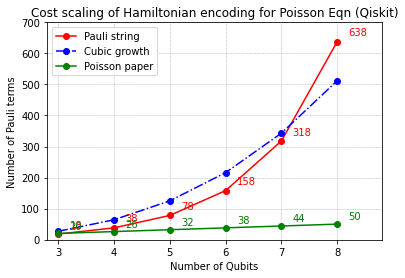

In [ ]:
qnum = [3,4,5,6,7,8]
num_pauli = [18,38,78,158,318,638]
pow_law = np.array(qnum)**3
ipm = [6*m+2 for m in qnum]
# print(pow_law)
plt.plot(qnum, num_pauli, 'ro-', label='Pauli string')
for i,j in zip(qnum,num_pauli):
    plt.text(i+0.2, j+20, str(j), color="red")
plt.plot(qnum, pow_law, 'bo-.', label='Cubic growth')
plt.plot(qnum, ipm, 'go-', label='Poisson paper')
for i,j in zip(qnum,ipm):
    plt.text(i+0.2, j+15, str(j), color="green")
plt.xlim([2.8, 8.8])
plt.ylim([-0.5, 700])
plt.legend(loc="best")
plt.xlabel('Number of Qubits')
plt.ylabel('Number of Pauli terms')
plt.title("Cost scaling of Hamiltonian encoding for Poisson Eqn (Qiskit)")
plt.grid(linestyle = '--', linewidth = 0.5)
# plt.savefig("scaling.png", bbox_inches='tight', dpi=300)